In [1]:
from matplotlib import colors
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import wrf
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from metpy.plots import USCOUNTIES
import pandas as pd
import matplotlib.ticker as mticker

mpl.rcParams['font.size'] = 14

In [2]:
from netCDF4 import Dataset
from metpy.units import units
wrfout = Dataset('/data/keeling/a/jcurtis2/d/bridges2_big_run/aerosols_d01_2010-06-17_00:00:00', "r", format="NETCDF4")
ozone = wrf.getvar(wrfout, "o3")
lats, lons = wrf.latlon_coords(ozone)
lats = wrf.to_np(lats)
lons = wrf.to_np(lons)

In [3]:
# To load the colormap from the JSON file and recreate it
import json
from matplotlib.colors import ListedColormap
with open('/data/keeling/a/xx24/colormap.json', 'r') as json_file:
    loaded_colors = json.load(json_file)
    loaded_colors = [(r / 255, g / 255, b / 255) for r, g, b in loaded_colors]
    cmap = ListedColormap(loaded_colors)

In [4]:
def nc_shape(var):
    da = xr.DataArray(
        data=var.T,
        dims=["south_north", "west_east"],
        coords=dict(
            lon=(["south_north", "west_east"], lons),
            lat=(["south_north", "west_east"], lats),
        ),
        attrs=dict(
            description="var",
            units="1",
        ),
    )
    return da
    
def rel_err(var_cs, var_vs):
    if np.any(var_vs == 0):
        result = np.zeros_like(var_cs)
    else:
        result = (var_cs - var_vs) / var_vs
    return -result*100

In [5]:
# surface
ccn_cs_00 = pd.read_csv('/data/keeling/a/xx24/d/proj_film/ccn_cs_00', sep=',', header=None)
ccn_vs_00 = pd.read_csv('/data/keeling/a/xx24/d/proj_film/ccn_vs_00', sep=',', header=None)

ccn_cs_12 = pd.read_csv('/data/keeling/a/xx24/d/proj_film/ccn_cs_12', sep=',', header=None)
ccn_vs_12 = pd.read_csv('/data/keeling/a/xx24/d/proj_film/ccn_vs_12', sep=',', header=None)
# 1km
ccn_cs_00_1km = pd.read_csv('/data/keeling/a/xx24/d/proj_film/ccn_cs_00_1km', sep=',', header=None)
ccn_vs_00_1km = pd.read_csv('/data/keeling/a/xx24/d/proj_film/ccn_vs_00_1km', sep=',', header=None)

ccn_cs_12_1km = pd.read_csv('/data/keeling/a/xx24/d/proj_film/ccn_cs_12_1km', sep=',', header=None)
ccn_vs_12_1km = pd.read_csv('/data/keeling/a/xx24/d/proj_film/ccn_vs_12_1km', sep=',', header=None)

In [6]:
ccn_error_00 = rel_err(ccn_cs_00,ccn_vs_00)
ccn_error_map_00 = nc_shape(ccn_error_00)
ccn_error_12 = rel_err(ccn_cs_12,ccn_vs_12)
ccn_error_map_12 = nc_shape(ccn_error_12)
ccn_error_00_1km = rel_err(ccn_cs_00_1km,ccn_vs_00_1km)
ccn_error_map_00_1km = nc_shape(ccn_error_00_1km)
ccn_error_12_1km = rel_err(ccn_cs_12_1km,ccn_vs_12_1km)
ccn_error_map_12_1km = nc_shape(ccn_error_12_1km)

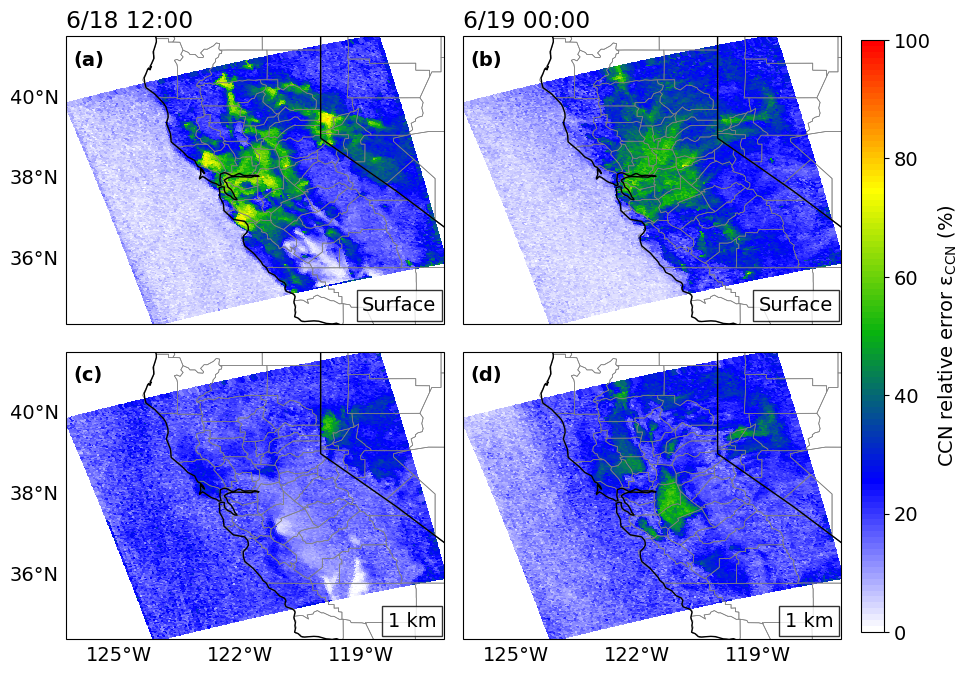

In [10]:
var_list = [ccn_error_map_00, ccn_error_map_12,
            ccn_error_map_00_1km, ccn_error_map_12_1km]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8),
                        subplot_kw=dict(projection=ccrs.PlateCarree()), 
                        gridspec_kw={'hspace': 0.05, 'wspace': 0.05})
fig.subplots_adjust(right=0.9)  # Adjust the right margin for the colorbar

# Add text labels to each subplot
labels = [f'({chr(97+i)})' for i in range(4)]  # Generate labels (a), (b), ...
for ax, label in zip(axs.flat, labels):
    ax.annotate(label, xy=(0.02, 0.95), xycoords='axes fraction', fontsize=14, fontweight='bold',
                horizontalalignment='left', verticalalignment='top')

for i, ax in enumerate(axs.flat):
    ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()])
    ax.add_feature(USCOUNTIES.with_scale('20m'), edgecolor='grey', linewidth=0.5)

    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

    ax.add_feature(states_provinces, edgecolor='black')
    ax.coastlines(resolution='50m', color='black', linewidth=1)

    
    var = var_list[i]

    im = ax.pcolormesh(lons, lats, var[:, :], vmin=0, vmax=100, transform=ccrs.PlateCarree(), cmap=cmap,
                       shading='auto', edgecolor='face', antialiased=False)

    if i == 1:
        position = fig.add_axes([0.92, 0.127, 0.023, 0.74])  # [left, bottom, width, height]
        cbar = plt.colorbar(im, ax=axs, cax=position)
        cbar.set_label(r"CCN relative error $\rm \varepsilon_{CCN}$ (%)")

    if i == 0:
        ax.set_title('6/18 12:00', loc='left')
    if i == 1:
        ax.set_title('6/19 00:00', loc='left')
    if i < 2:
        ax.text(0.98, 0.03, 'Surface', transform=ax.transAxes, ha='right', va='bottom', bbox=dict(facecolor='white', edgecolor='black', alpha=0.8))
    else:
        ax.text(0.98, 0.03, '1 km', transform=ax.transAxes, ha='right', va='bottom', bbox=dict(facecolor='white', edgecolor='black', alpha=0.8))

    # Add gridlines with labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0, color='none')  # No grid lines
    
    # Customize longitude labels
    gl.xlocator = mticker.FixedLocator(range(-125, -116, 3))
    
    # Customize latitude labels
    gl.ylocator = mticker.FixedLocator(range(int(lats.min()), int(lats.max()), 2))  
    
    # Only show latitude labels on the left two subplots
    if i % 2 == 0:  # Left subplots
        gl.left_labels = True
    else:
        gl.left_labels = False
    
    # Only show longitude labels on the bottom two subplots
    if i >= 2:  # Bottom subplots
        gl.bottom_labels = True
    else:
        gl.bottom_labels = False
    
    gl.top_labels = False
    gl.right_labels = False


plt.savefig('/data/keeling/a/xx24/d/proj_film/ccn_rel_err_surface_and_1km.pdf', bbox_inches='tight')
plt.show()

In [11]:
levels = {
    "Surface": {"6/18 12:00": ccn_error_map_00, "6/19 00:00": ccn_error_map_12},
    "1 km": {"6/18 12:00": ccn_error_map_00_1km, "6/19 00:00": ccn_error_map_12_1km},
}

for level, times in levels.items():
    for time_label, da in times.items():
        avg_val = da.mean().item()  
        max_val = da.max().item()   
        print(f"{time_label} {level}: average = {avg_val:.2f}%, max = {max_val:.2f}%")

6/18 12:00 Surface: average = 21.01%, max = 80.85%
6/19 00:00 Surface: average = 21.12%, max = 70.01%
6/18 12:00 1 km: average = 18.74%, max = 57.45%
6/19 00:00 1 km: average = 20.03%, max = 61.48%


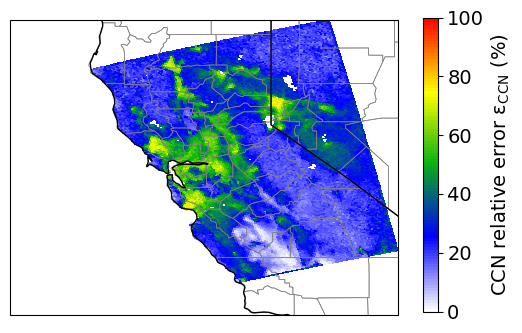

In [19]:
wrfinput = Dataset('/data/keeling/a/jcurtis2/d/bridges2_big_run/wrfinput_d01', "r", format="NETCDF4")
land_mask = wrfinput['LANDMASK'][0,:,:].T

fig, ax = plt.subplots(figsize=(5, 4), subplot_kw=dict(projection=ccrs.PlateCarree()))

ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()])
ax.add_feature(USCOUNTIES.with_scale('20m'), edgecolor='grey', linewidth=0.5)

states_provinces = cartopy.feature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

ax.add_feature(states_provinces, edgecolor='black')
ax.coastlines(resolution='50m', color='black', linewidth=1)


im = ax.pcolormesh(lons, lats, nc_shape(ccn_error_00*land_mask)[:, :], vmin=0, vmax=100, transform=ccrs.PlateCarree(), cmap=cmap)


position = fig.add_axes([0.95, 0.135, 0.03, 0.735])#位置[左,下,右,上]
cbar = plt.colorbar(im, ax=ax, cax=position)
cbar.set_label(r"CCN relative error $\rm \varepsilon_{CCN}$ (%)")